# Red Giant Classification Project

**The goal - predicting the evolutionary stage of Red Giant stars**

## initializing

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# all altair plots were saved and uploaded as pictures to lighten the notebook
while True:
    try:
        import altair as alt
        break
    except ModuleNotFoundError:
        !pip install altair

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

### plotting defs

In [232]:
def plot_target_distro(data, target='phase'):
    
    base = alt.Chart(data).encode(
        x=alt.X('phase:N', title=None, ),
        y=alt.Y(f'count({target}):Q', title=None)
    ).properties(width=300)

    bar = base.mark_bar(
        size=100,
        color='indianred')

    text = base.mark_text(
        baseline='top', dy=20,
        size=25, color='mistyrose'
    ).encode(text=f'count({target}):Q')

    return bar+text

In [131]:
def plot_confusion_matrix(conf_df):

    base = alt.Chart(
        conf_df.reset_index().melt(id_vars='index'),
        title='confusion matrix'
    ).encode(x=alt.X('index:N', title=None),
             y=alt.Y('variable:N', title=None)
             ).properties(height=150, width=150)

    heatmap = base.mark_rect().encode(
        color=alt.Color('value:Q',
                        scale=alt.Scale(
                            scheme='reds'),
                        legend=None))

    text = base.mark_text(
        baseline='middle', size=25
    ).encode(text='value:Q',
             color=alt.condition(
                 'datum.value < 3000',
                 alt.value('darkred'),
                 alt.value('tomato'))
             ).encode()

    return heatmap+text

In [178]:
def plot_feature_importances(model):

    features = model.feature_names_in_
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_

    elif hasattr(model, 'steps'):
        name, estimator = model.steps[-1]
        importances = estimator.feature_importances_

    else:
        print('no feature importances for this model')
        pass
        
    feat_chart = alt.Chart(pd.DataFrame(
        {'feature': features, 'importance': importances}
    ).sort_values('importance').tail(10),
        title='feature importances').mark_bar(
        color='firebrick').encode(
        y=alt.Y('feature:N', sort='-x', title=None),
        x=alt.X('importance:Q', title=None, axis=alt.Axis(format='.0%'))
    ).properties(height=150, width=400)
    
    return feat_chart

In [135]:
def plot_clf_results(model, X, y):

    conf = plot_confusion_matrix(
        pd.DataFrame(
            confusion_matrix(y, model.predict(X),
                             labels=model.classes_),
            index=model.classes_,
            columns=model.classes_))

    feat = plot_feature_importances(model)

    return conf | feat

## small exploration

In [13]:
upload = pd.read_csv('/'.join(['https:/',
                               'raw.githubusercontent.com',
                               'Morshay',
                               'red-giant-blue-giant',
                               'main',
                               'data',
                               'clean_data.csv']))

### data overview

In [14]:
init_df = upload.copy()
print(init_df.info())
init_df.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15388 entries, 0 to 15387
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   phase   15388 non-null  object 
 1   ap_mag  15388 non-null  float64
 2   freq    15388 non-null  float64
 3   fr_sep  15388 non-null  float64
 4   amp     14851 non-null  float64
 5   pow_ex  14851 non-null  float64
 6   temp    15388 non-null  int64  
 7   grav    15388 non-null  float64
 8   metal   15388 non-null  float64
 9   rad     15388 non-null  float64
 10  mass    15388 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 1.3+ MB
None


,phase,ap_mag,freq,fr_sep,amp,pow_ex,temp,grav,metal,rad,mass
15145,RGB,13.73,34.18,3.959,124.0,12.1,4742,2.439,0.19,34.71,4.02
4141,RGB,13.41,60.48,6.040,94.9,19.6,4783,2.689,-0.31,26.20,4.08
7790,RGB,13.38,84.98,8.065,73.4,25.0,5021,2.847,-0.23,21.53,3.96
262,HeB,12.57,34.04,3.920,111.6,15.9,4629,2.432,0.40,34.63,3.94
11372,HeB,10.68,28.06,3.491,110.5,11.8,4769,2.355,0.01,36.67,3.70
5187,RGB,11.92,41.07,4.365,111.7,14.1,4689,2.516,0.24,34.06,4.64
754,HeB,11.94,28.14,3.741,150.9,11.8,4817,2.358,-0.25,32.10,2.86
6582,HeB,13.60,34.82,4.136,99.4,15.7,4833,2.451,0.04,32.76,3.69
4800,HeB,13.59,27.56,3.411,86.1,12.7,4984,2.356,-0.67,38.59,4.11
14230,HeB,13.41,105.23,8.172,26.6,52.2,5305,2.952,-0.35,27.51,8.24


In [234]:
# plot_target_distro(init_df)

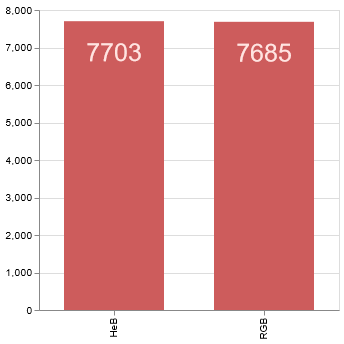

### quick test

prior to testing - success in my view would be around 80% precision, and 90% would be a smashing hit.

In [16]:
def quick_test(data, target='phase'):

    X, y = data.drop(columns='phase').fillna(0), data.phase

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=.3, random_state=6582119, stratify=y, shuffle=True)

    m = RandomForestClassifier(
        max_samples=.25, n_estimators=10, random_state=6582119)

    m.fit(X_train, y_train)
    
    res_train = plot_clf_results(m, X_train, y_train).properties(title='TRAIN')

    res_test = plot_clf_results(m, X_test, y_test).properties(title='TEST')

    return res_train & res_test

In [17]:
def print_clf_report(data, target='phase'):
    
    X, y = data.drop(columns='phase').fillna(0), data.phase

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=.3, random_state=6582119, stratify=y, shuffle=True)

    m = RandomForestClassifier(
        max_samples=.25, n_estimators=10, random_state=6582119)
    
    m.fit(X_train, y_train)
    
    print(classification_report(y_test, m.predict(X_test), target_names=m.classes_))

In [185]:
# quick_test(init_df)

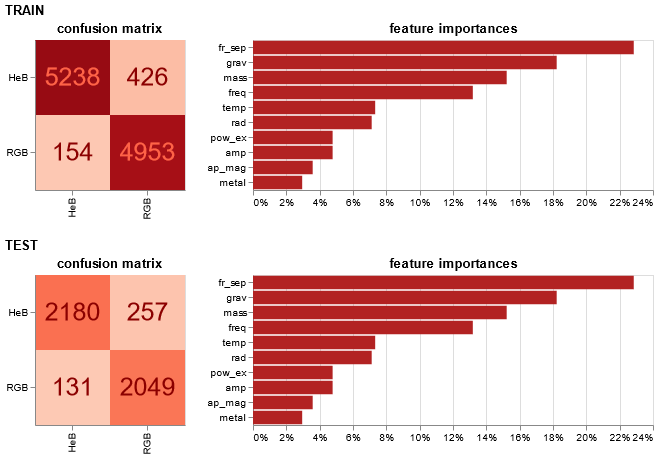

In [19]:
print_clf_report(init_df)

              precision    recall  f1-score   support

         HeB       0.89      0.94      0.92      2311
         RGB       0.94      0.89      0.91      2306

    accuracy                           0.92      4617
   macro avg       0.92      0.92      0.92      4617
weighted avg       0.92      0.92      0.92      4617



just because the results are great, doesn't mean that nothing can be done with the data.

In [236]:
df = init_df.copy()

## feature engineering

### feature selection

In [237]:
feat_df = df.copy()

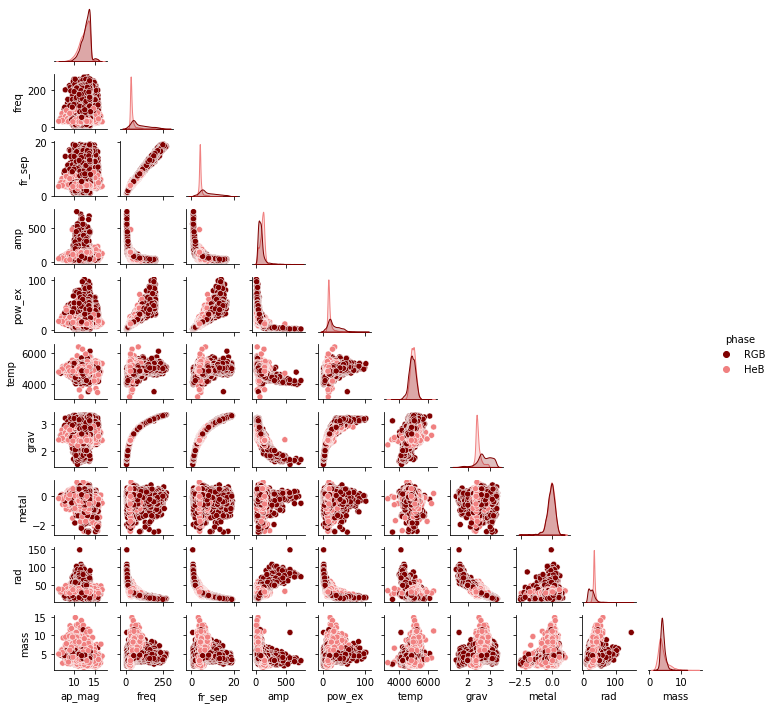

In [238]:
sns.pairplot(
    feat_df, height=1, corner=True,
    hue='phase', palette=['maroon', 'lightcoral'])

there seems to be a clear mapping between each of the following five columns:
- frequency
- freq. sep.
- amplitude
- power excess
- gravity
- radius

weirdly enough, the mass column is pretty unrelated to those.

the only column there which has an even distribution between the two classes is the amplitude column.  
it'll be the one to keep, expecting the results to go down.

In [190]:
feat_df.drop(columns=['freq', 'fr_sep', 'pow_ex', 'grav', 'rad'], inplace=True)

In [192]:
# quick_test(feat_df)

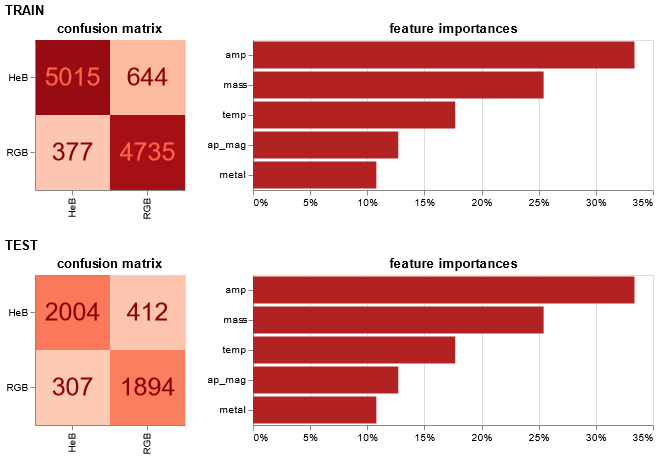

In [26]:
df = feat_df.copy()

### nulls

In [27]:
null_df = df.copy()

In [28]:
tot_nulls = len(null_df[null_df.isnull().any(axis='columns')])

print(f'{tot_nulls/len(null_df):.2%}')

3.49%


In [29]:
null_df.columns[null_df.isnull().sum() > 0]

Index(['amp'], dtype='object')

totally negeligible, still i'll fill those in with group means, using the metallicity column to group by, since it's the most evenly distributed.

In [30]:
null_df['bins'] = pd.cut(null_df.metal, bins=10)
null_df.bins.value_counts()

(-0.4, -0.05]      6318
(-0.05, 0.3]       5807
(-0.75, -0.4]      1895
(0.3, 0.65]         848
(-1.1, -0.75]       360
(-1.45, -1.1]        92
(-1.8, -1.45]        28
(-2.15, -1.8]        19
(0.65, 1.0]          13
(-2.504, -2.15]       8
Name: bins, dtype: int64

In [31]:
null_df.amp.fillna(null_df.groupby(
    ['bins'])['amp'].transform('mean'), inplace=True)
null_df.isna().any(axis=1).sum()

0

In [32]:
null_df.drop(columns='bins', inplace=True)

In [194]:
# quick_test(null_df)

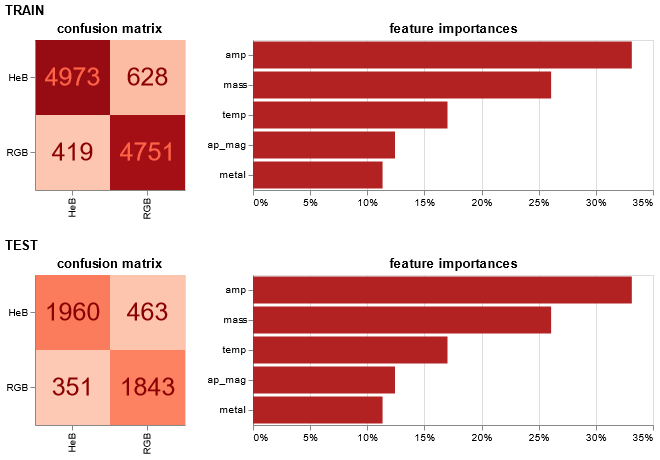

well, that went horribly wrong. maybe it's time to try a different approach.

### a different approach

in this approach, i let sklearn do its thing and not intervene.

In [34]:
auto_df = init_df.copy()

In [35]:
y = auto_df.phase
X = auto_df.drop(columns='phase')

null filling

In [36]:
imputer = SimpleImputer()
X_imp = pd.DataFrame(
    imputer.fit_transform(X),
    columns=X.columns)

feature selection

In [37]:
selector = SelectKBest()
X_slc = pd.DataFrame(
    selector.fit_transform(X_imp, y),
    columns = X_imp.columns[selector.get_support()])

testing

In [38]:
final_df = pd.concat([df.phase, X_slc], axis=1)

In [200]:
# quick_test(final_df)

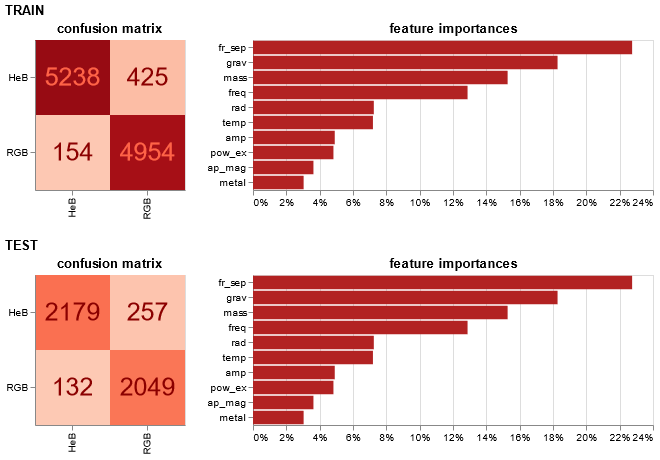

In [40]:
print_clf_report(final_df)

              precision    recall  f1-score   support

         HeB       0.89      0.94      0.92      2311
         RGB       0.94      0.89      0.91      2306

    accuracy                           0.92      4617
   macro avg       0.92      0.92      0.92      4617
weighted avg       0.92      0.92      0.92      4617



nothing changed from the start, but it's the thought that matters.

## models

now that the data is in its 'final' form (which is exactly the initial form but i'll leave that aside),  
i can test it on different models and optimize them using a grid search, to see which one fits the data best.

In [41]:
X, y = final_df.drop(columns='phase'), final_df.phase

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=6582119, stratify=y, shuffle=True)

### comparison

**random forest**

In [42]:
forest_base = RandomForestClassifier(
    max_samples=.25, n_estimators=10
).fit(X_train, y_train)

forest_params = {'n_estimators': [50, 100, 150],
              'max_samples': [.15, .2, .25, .3, .35]}

forest_gs = GridSearchCV(
    forest_base, forest_params, cv=5
).fit(X_train, y_train)

forest_gs.best_params_

{'max_samples': 0.3, 'n_estimators': 100}

**SVM**

In [44]:
svm_base = SVC(gamma=1e-3, C=10).fit(X_train, y_train)

svm_params = {'gamma': [1e-4, 1e-3, 1e-2],
              'C': [1, 10, 100]}

svm_gs = GridSearchCV(svm_base, svm_params, cv=5)
svm_gs.fit(X_train, y_train)
svm_gs.best_params_

{'C': 100, 'gamma': 0.0001}

**logistic regression**

In [53]:
scaler = StandardScaler()
Xtr_scl = scaler.fit_transform(X_train, y_train)
Xts_scl = scaler.fit_transform(X_test, y_test)

logit_base = LogisticRegression(
    max_iter=300, C=10).fit(Xtr_scl, y_train)

logit_params = {'max_iter': [100, 300, 500],
              'C': [.1, 1, 10, 100, 1000]}

logit_gs = GridSearchCV(
    logit_base, logit_params, cv=5
).fit(Xtr_scl, y_train)
logit_gs.best_params_

{'C': 100, 'max_iter': 100}

**gradient boosting**

In [50]:
grad_base = GradientBoostingClassifier(
    n_estimators=100, max_depth=5).fit(X_train, y_train)

grad_params = {'n_estimators': [50, 100, 150],
              'max_depth': [3, 5, 7]}
grad_gs = GridSearchCV(grad_base, grad_params, cv=5)
grad_gs.fit(X_train, y_train)
grad_gs.best_params_

{'max_depth': 7, 'n_estimators': 150}

### model comparison

In [99]:
scores_df = pd.DataFrame(
    columns=['model', 'stage', 'score'],
    data=[['forest', 'train', forest_gs.score(X_train, y_train)],
          ['forest', 'test', forest_gs.score(X_test, y_test)],
          ['svm', 'train', svm_gs.score(X_train, y_train)],
          ['svm', 'test', svm_gs.score(X_test, y_test)],
          ['logit', 'train', logit_gs.score(Xtr_scl, y_train)],
          ['logit', 'test', logit_gs.score(Xts_scl, y_test)],
          ['grad', 'train', grad_gs.score(X_train, y_train)],
          ['grad', 'test', grad_gs.score(X_test, y_test)]])

In [98]:
# alt.Chart(scores_df).mark_bar().encode(
#     x=alt.X('type:N', axis=None, sort='-x'),
#     y=alt.Y('score:Q', axis=alt.Axis(format='%'),
#             scale=alt.Scale(domain=(.9, 1))),
#     color=alt.Color('type:N', sort=['train', 'test'],
#                     scale=alt.Scale(scheme='reds')),
#     column='model:N').properties(width=100)

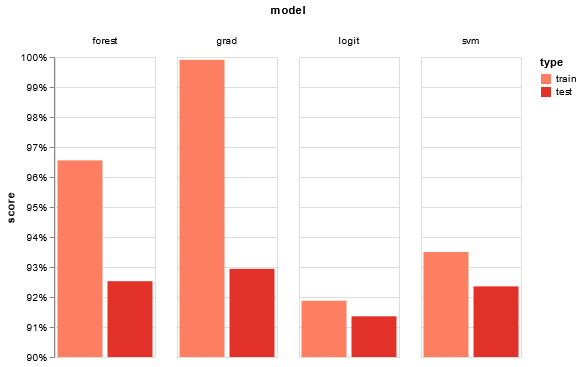

gradient boosting is the way to go, but not by much.

## pipeline

In [167]:
X, y = init_df.drop(columns='phase'), init_df.phase

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=6582119, stratify=y, shuffle=True)

In [149]:
pipeline = Pipeline([('imputer', SimpleImputer()),
                     ('selector', SelectKBest()),
                     ('model', GradientBoostingClassifier(
                         **grad_gs.best_params_,
                         random_state=6582119))
                     ]).fit(X_train, y_train)

### results

In [150]:
print(classification_report(y_test, pipeline.predict(X_test),
                      target_names=pipeline.classes_))

              precision    recall  f1-score   support

         HeB       0.93      0.93      0.93      2311
         RGB       0.93      0.93      0.93      2306

    accuracy                           0.93      4617
   macro avg       0.93      0.93      0.93      4617
weighted avg       0.93      0.93      0.93      4617



In [202]:
# res_train = plot_clf_results(
#     pipeline, X_train, y_train
# ).properties(title='TRAIN')

# res_test = plot_clf_results(
#     pipeline, X_test, y_test
# ).properties(title='TEST')

# res_train & res_test

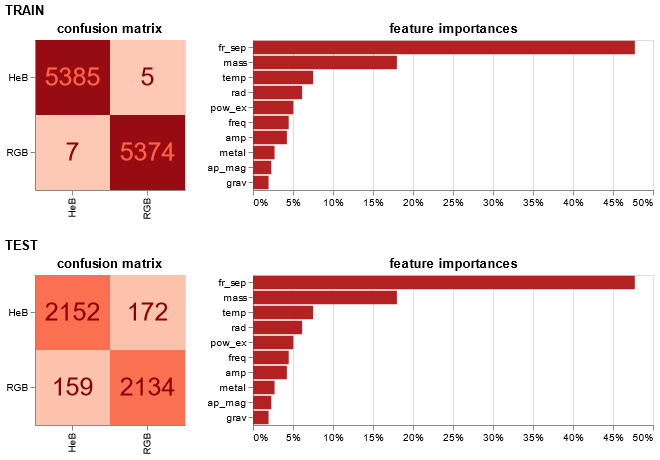

### error analysis

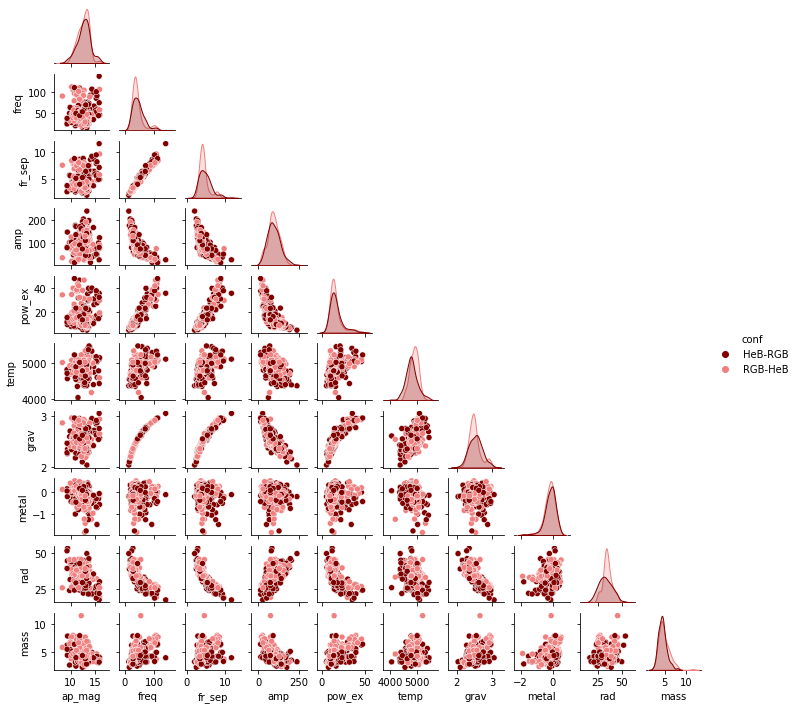

In [231]:
errors_df = X_test.assign(phase=y_test, pred=pipeline.predict(X_test))

errors_df['conf'] = errors_df.phase + '-' + errors_df.pred

sns.pairplot(data=errors_df.loc[errors_df['phase'] != errors_df['pred']],
             hue='conf', palette=['maroon', 'lightcoral'], corner=True, height=1)

the prediction errors in are scattered all over the place, so there's no apparent threshold to adjust.